# VSE CA1 Part1

### Team
Kenneth Goh Chia Wei : A0198544N  
Tan Heng Han : A0198502B  
Raymond Ng Boon Cheong : A0198543R

In [1]:
import urllib.request
import shutil
import imgaug as ia
import os
from YOLO_API import *

In [2]:
# Download YOLOV3 Pretrained Weights
# This is a shortcut to download the pretrained weights, please ensure that the pretrained weights are fully downloaded before executing further cells
# If download code does not work, please cut and paste URL link below and paste into a browser address field to begin download
url = 'https://drive.google.com/file/d/1Y0E928LRsa1qmP_5P8jHfzSbI8A9T2Pb/view?usp=sharing'
with urllib.request.urlopen(url) as response, open('Yolov3_pretrained_weights.h5', 'wb') as out_file:
    shutil.copyfileobj(response, out_file)

In [6]:
# Dataset directory
img_dir = "../data/image/"
anno_dir = "../data/annotation/"
model_weights = 'Final_YOLOv3_Weights.h5'

In [7]:
# Construct YOLOv3 API object
yoloAPI = YoloV3_API(
    img_dir=img_dir,
    annotation_dir=anno_dir,
    saved_model_name=model_weights,
    train_size=0.8,
    height=416,
    width=416,
    threshold=0.3,
    batch_size=2)

Image directory: ../data/image/
Annotation directory: ../data/annotation/
Saved model name: Final_YOLOv3_Weights.h5
Train/validation size ratio: 0.8
Training size: 416x416
Threshold: 0.3
Batch Size: 2

All Image and annotation size: 765
Unique labels: dict_keys(['car', 'bus'])
Generated Anchor Boxes: [8, 10, 14, 18, 24, 26, 35, 46, 41, 29, 48, 94, 64, 48, 85, 76, 92, 120]

Training image and annotation size: 612
Validation image and annotation size: 153
Maximum bounding boxes in all images: 15

Train Generator created: To access, use <YoloV3_API.train_generator>
Validation Generator created: To access, use <YoloV3_API.valid_generator>

Loading pretrained weights
YOLOv3 Training Model created: To access, use <YoloV3_API.train_model>

YOLOv3 Inference Model created: To access, use <YoloV3_API.infer_model>

Train Model Summary
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     

In [11]:
%%time
history = yoloAPI.fit_generator(epoch=300, lr=1e-4)


Epoch 1/300
204/204 [==============================] - 121s 594ms/step - loss: 55.9502 - yolo_loss_layer_4_loss: 10.0660 - yolo_loss_layer_5_loss: 12.0076 - yolo_loss_layer_6_loss: 31.5455 - val_loss: 77.5138 - val_yolo_loss_layer_4_loss: 15.5045 - val_yolo_loss_layer_5_loss: 21.5250 - val_yolo_loss_layer_6_loss: 38.1523

Epoch 00001: loss improved from inf to 55.95018, saving model to yolo_model.h5
Epoch 2/300
204/204 [==============================] - 90s 444ms/step - loss: 30.1842 - yolo_loss_layer_4_loss: 5.4354 - yolo_loss_layer_5_loss: 6.5401 - yolo_loss_layer_6_loss: 15.8763 - val_loss: 62.8376 - val_yolo_loss_layer_4_loss: 39.0894 - val_yolo_loss_layer_5_loss: 6.2786 - val_yolo_loss_layer_6_loss: 15.1370

Epoch 00002: loss improved from 55.95018 to 30.18419, saving model to yolo_model.h5
Epoch 3/300
204/204 [==============================] - 92s 451ms/step - loss: 25.7874 - yolo_loss_layer_4_loss: 4.9218 - yolo_loss_layer_5_loss: 5.6681 - yolo_loss_layer_6_loss: 12.8652 - val_

In [8]:
# Get all test images
imgpath = '../data/test_image/'
test_images = os.listdir(imgpath)

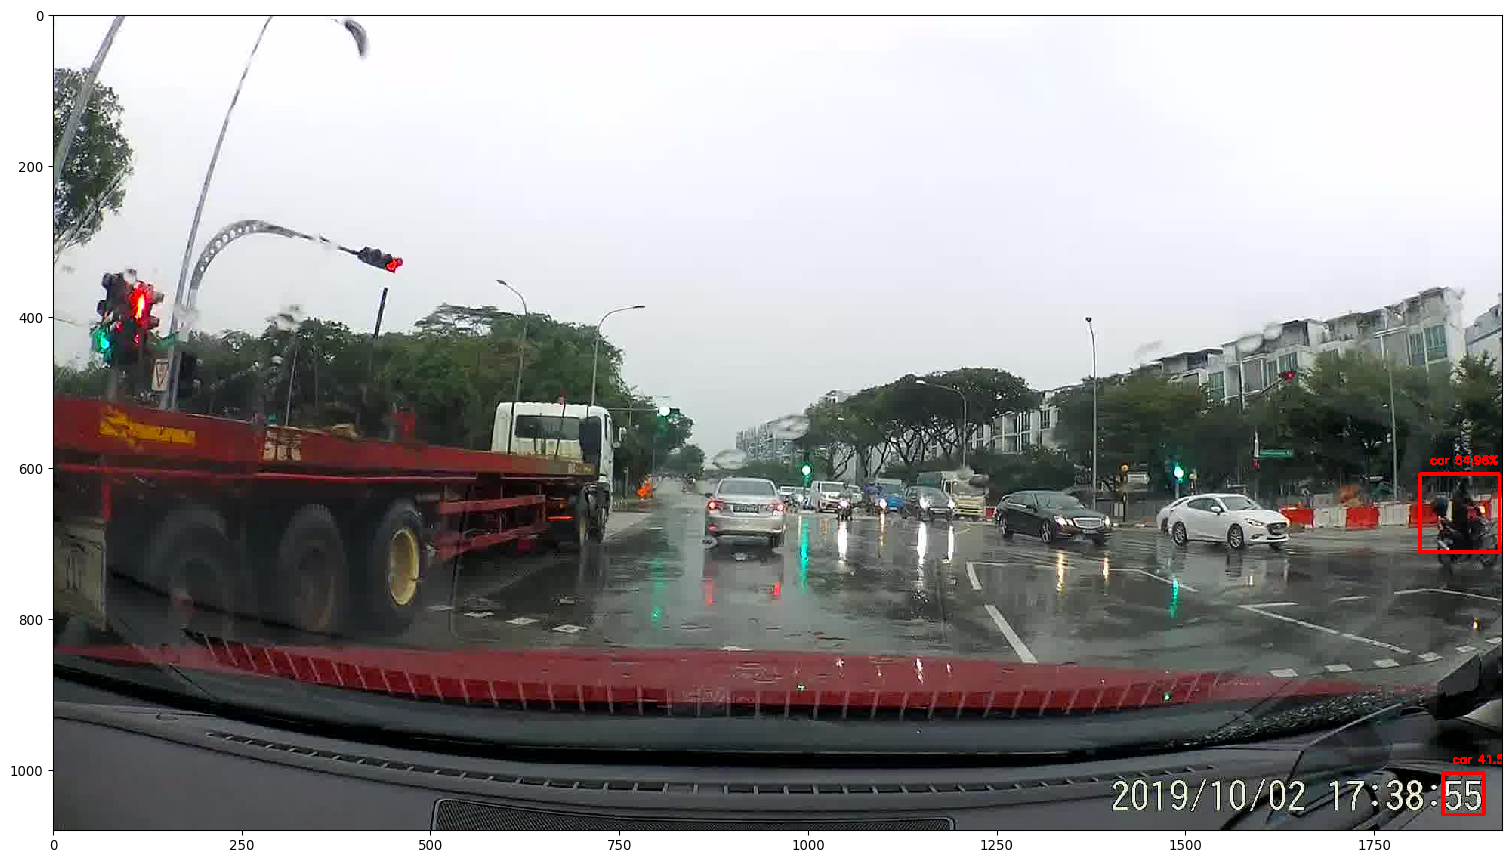

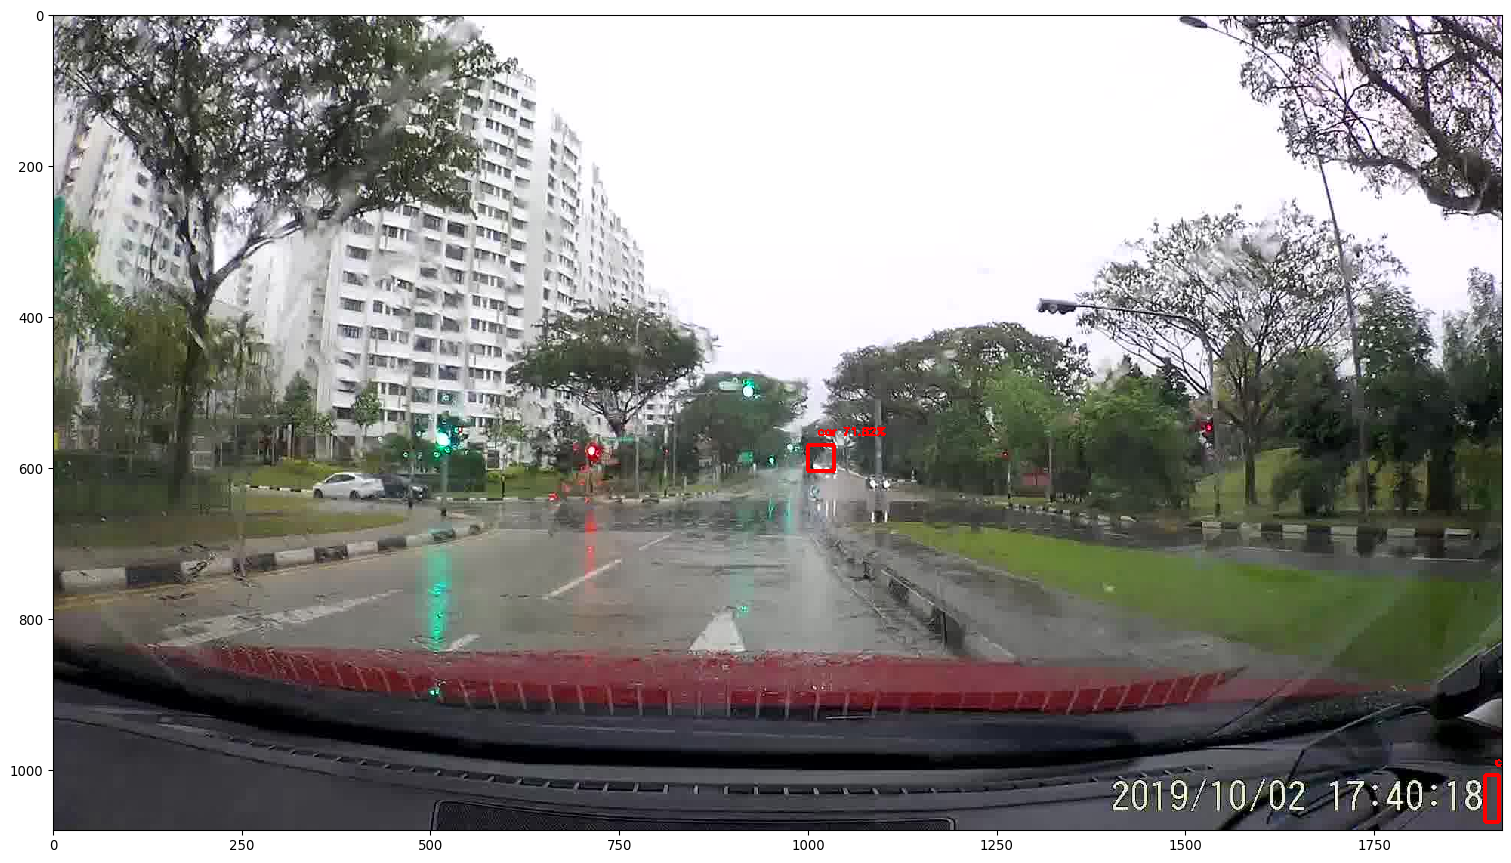

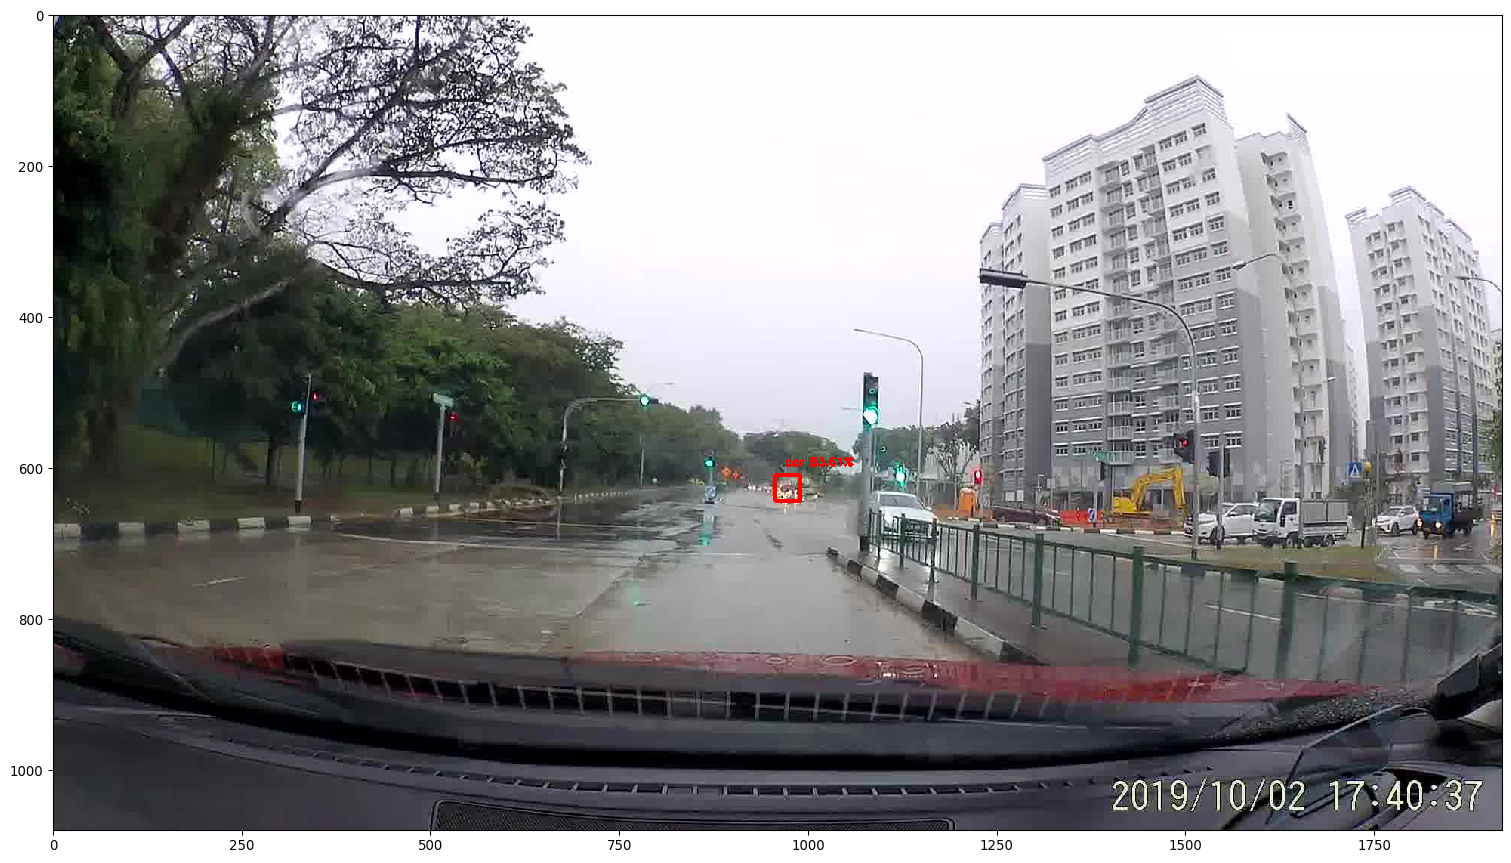

In [9]:
for img in test_images:
    img, pred = yoloAPI.predict(os.path.join(imgpath, img))
    img = yoloAPI.draw_prediction(img, pred)
    ia.imshow(img)

In [27]:
print(history.history.keys())

dict_keys(['val_loss', 'val_yolo_loss_layer_4_loss', 'val_yolo_loss_layer_5_loss', 'val_yolo_loss_layer_6_loss', 'loss', 'yolo_loss_layer_4_loss', 'yolo_loss_layer_5_loss', 'yolo_loss_layer_6_loss', 'lr'])


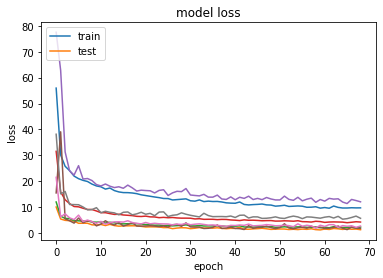

In [30]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['yolo_loss_layer_4_loss'])
plt.plot(history.history['yolo_loss_layer_5_loss'])
plt.plot(history.history['yolo_loss_layer_6_loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_yolo_loss_layer_4_loss'])
plt.plot(history.history['val_yolo_loss_layer_5_loss'])
plt.plot(history.history['val_yolo_loss_layer_6_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Model Conversion for OPENCV

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras_to_tensorflow_convertor import convert_keras_to_tensorflow

In [11]:
KERAS_MODEL_NAME = 'yolo_keras_model.h5'
TF_MODEL_NAME = 'yolo_tf_model.pb'

In [12]:
# Save the inference model
frozen_model = yoloAPI.infer_model
frozen_model.load_weights(model_weights)
frozen_model.save(KERAS_MODEL_NAME)

In [13]:
# This will perform the conversion from Keras model to Tensorflow model
convert_keras_to_tensorflow(KERAS_MODEL_NAME, TF_MODEL_NAME)

D:\Anaconda3\envs\rtav\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


INFO:tensorflow:Froze 366 variables.
INFO:tensorflow:Converted 366 variables to const ops.


In [63]:
def yoloV3Detect(img, scFactor=1/255, nrMean=(0,0,0), RBSwap=True, scoreThres=0.5, nmsThres=0.4):
    net = loadYoloV3Model()
    blob = cv2.dnn.blobFromImage(image=img,
                                scalefactor=scFactor,
                                size=(416,416),
                                mean=nrMean,
                                swapRB=RBSwap,
                                crop=False)
    net.setInput(blob)
    outLyrs = getOutputLayers(net)
    org_preds = net.forward(outLyrs)
    preds = []
    for p in org_preds:
        preds.append(np.transpose(p, (0,2,3,1)))
    pred_boxes = yoloAPI.process_prediction(img, preds)
    return pred_boxes

In [64]:
def getClasses():
    return ['car','bus']

In [65]:
def getOutputLayers(net):
    layers = net.getLayerNames()
    return [layers[i[0]-1] for i in net.getUnconnectedOutLayers()]

In [66]:
def loadYoloV3Model():
    return cv2.dnn.readNetFromTensorflow(TF_MODEL_NAME)

In [67]:
# Read image and start detection
img = cv2.imread(os.path.join(imgpath, test_images[2]))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
pred_boxes = yoloV3Detect(img)

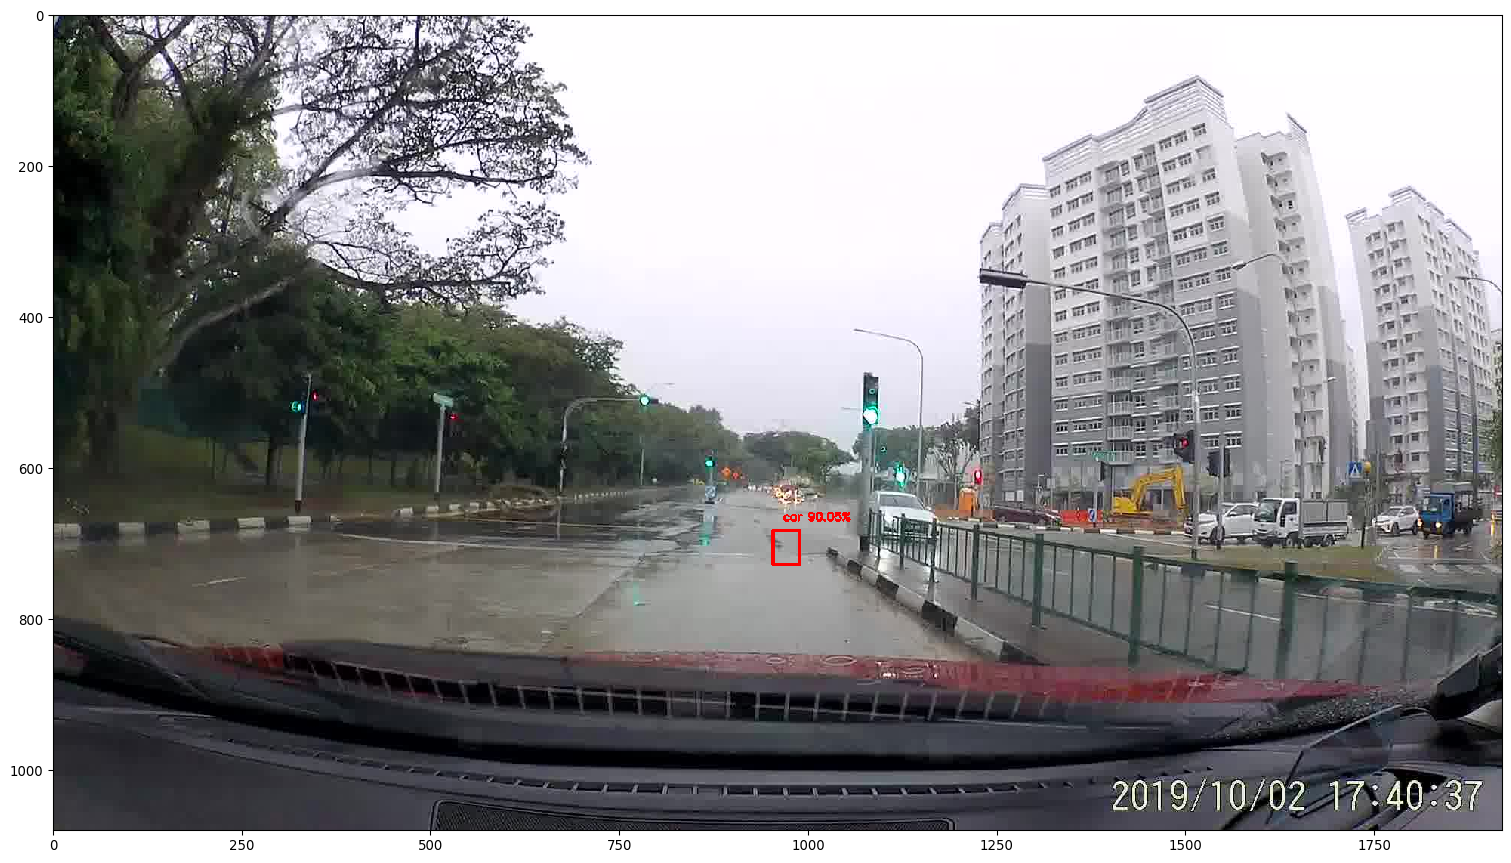

In [68]:
# Draw detection on image and display
cvimg = yoloAPI.draw_prediction(img, pred_boxes)
ia.imshow(cvimg)